In [13]:
fft_size = 256
samples = 1024 * 512
freq = 100
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq) * 0.25
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
forward_input_signal = sine + noise * 8

forward_input_signal = f + (np.random.uniform(-1, 1, len(f)) + np.random.uniform(-1, 1, len(f)) * 1j) * 0.01
# for
# forward_input_signal *= 0.000001

In [14]:
512*256

131072

(256, 512)


<IPython.core.display.Javascript object>


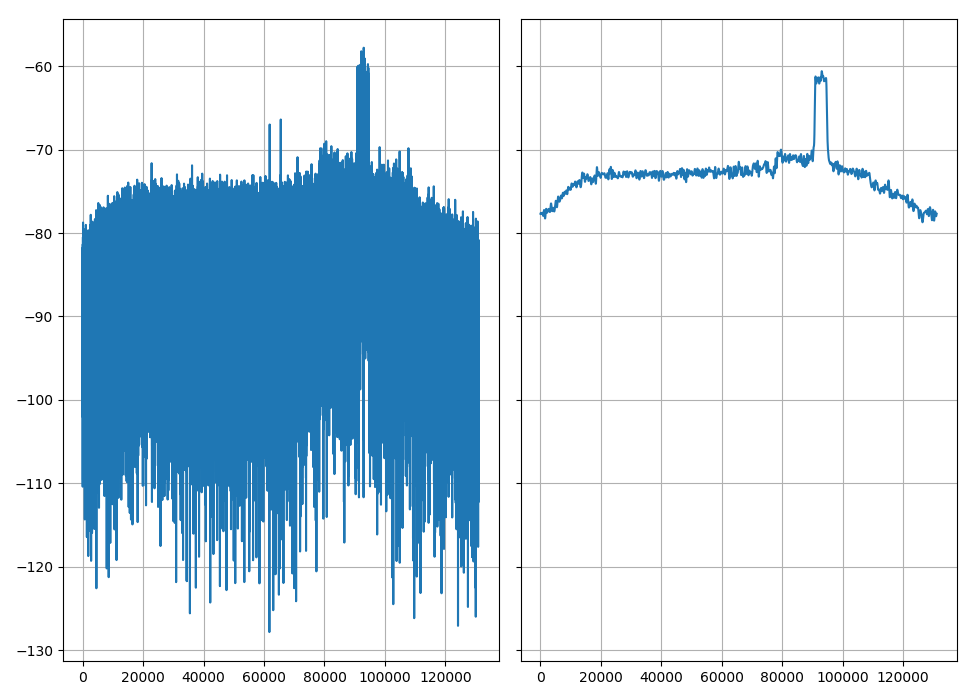

In [18]:
import scipy
fig = plt.figure(figsize=(9.75, 7))
axes = fig.subplots(1, 2, sharey='all')
# forward_input_signal *= 0.000001

fl = 512*256
fo = np.log10(np.abs(np.fft.fftshift(np.fft.fft(forward_input_signal, fl)/fl))) * 20
# fo = scipy.signal.resample(fo, 512)
axes[0].plot(fo)
axes[0].grid()

# plt.plot(np.log10(np.abs(np.fft.fftshift(np.fft.fft(forward_input_signal, 1024)*2))) * 20)
# plt.show()
p = 512
f512 = forward_input_signal[:fl].reshape((-1, p))
print(f512.shape)
f512 = np.log10(np.abs(np.fft.fftshift(np.fft.fft(f512) / p))) * 20 - 12
f512 = np.mean(f512, axis=0)
# f512 = f512[0]
f512 = scipy.signal.resample(f512, fl)
axes[1].plot(f512)
axes[1].grid()
plt.tight_layout()
# plt.ylim([-45, -5])
plt.show()

# fig = plt.figure(figsize=(9.75, 7))
# plt.plot(f512)
# plt.show()



In [6]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from pylab import rcParams
# rcParams['figure.figsize'] = 10, 5
rcParams['figure.max_open_warning'] = False
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.signal import spectral

def spectrogram(iq, fft_points=512):
    _, _, out = spectral.spectrogram(iq, 1, nperseg=fft_points, scaling='spectrum', return_onesided=False, detrend=False,
                                     noverlap=0, window='hann')
    
    # int(fft_points * (1.0 - 2**-7))
    out = np.roll(out, fft_points//2, axis=0)
    return out

def show_plot():
    import matplotlib.pyplot as plt
    plt.tight_layout()
    

    
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()


def imshow_rescale(im, rescale=True):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(9.75, 5))
    im = np.array(im)
    if rescale:
        from skimage.exposure import exposure
        p2, p98 = np.percentile(im, (2, 98))
        im = exposure.rescale_intensity(im, in_range=(p2, p98))

    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    show_plot()

def load_complex64_file(file: str):
    import scipy as sp
    f = sp.fromfile(open(file), dtype=sp.complex64)
    return f



def preprocess(spectrogram, spect_shrink, stride_y=8, stride_x=8):
    def reduce_length_by_average(x2d, new_lenght, axis='x'):
        """ For example 1024 point FFT averaged to 128 points
        x2d: 2d array
        new_lenght: integer new length for axis
        axis: 'x' to reduce x axis, 'y' to reduce y axis
        """
        # x2d = np.array(x2d)
        if axis == 'y' or axis == 1:
            x2d = x2d.T

        x2d = x2d[:, :(len(x2d[0]) // new_lenght) * new_lenght]  # make out divisible with new_dim

        x2d = np.split(x2d, new_lenght, axis=1)  # split the time axsis
        x2d = np.average(x2d, axis=2).T  # reduce the splits into one average, gives fft_n X new_dim image

        if axis == 'y' or axis == 1:
            x2d = x2d.T

        return x2d

    def slide_windows_and_scale(x2d, stride_y=8, stride_x=8, window_y=32, window_x=32):
        """ Turns 2D input into list of overlapped windows (strides and window sizes), each region is max scaled"""
        parts = []
        # print(len(list(range(0, x2d.shape[0] - window_y + stride_y, stride_y))))
        # print(len(list(range(0, x2d.shape[1] - window_x, stride_x))))
        for y in range(0, x2d.shape[0] - window_y + stride_y, stride_y):
            for x in range(0, x2d.shape[1] - window_x, stride_x):
                l = x2d[y:y + window_y, x:x + window_x]
                parts.append(l)

        parts = np.array(parts)
        scales = np.max(parts.reshape((parts.shape[0], -1)), axis=1).reshape((parts.shape[0], 1, 1))
        norm_parts = parts / scales
        return norm_parts, scales

    if spect_shrink['y'] > 1:
        spectrogram = reduce_length_by_average(spectrogram, new_lenght=spectrogram.shape[0] // spect_shrink['y'],
                                               axis='y')

    if spect_shrink['x'] > 1:
        spectrogram = reduce_length_by_average(spectrogram, new_lenght=spectrogram.shape[1] // spect_shrink['x'],
                                               axis='x')

    parts, scales = slide_windows_and_scale(spectrogram, stride_x=stride_x, stride_y=stride_y)
    return spectrogram, parts, scales

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
f = load_complex64_file('/home/gaspar/dji_recording_2')
print(len(f)*(1/40e6), len(f))
end = int(100e-3 // (1/40e6))
print(len(f) / end)
print(end)
f = f[:end]

1.142336 45693440
11.42336
4000000


In [28]:
import scipy

<IPython.core.display.Javascript object>


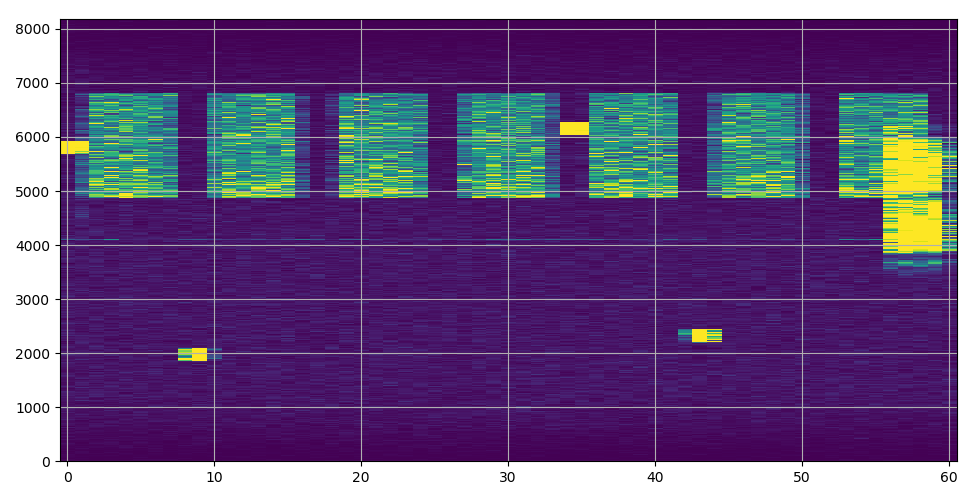

<IPython.core.display.Javascript object>


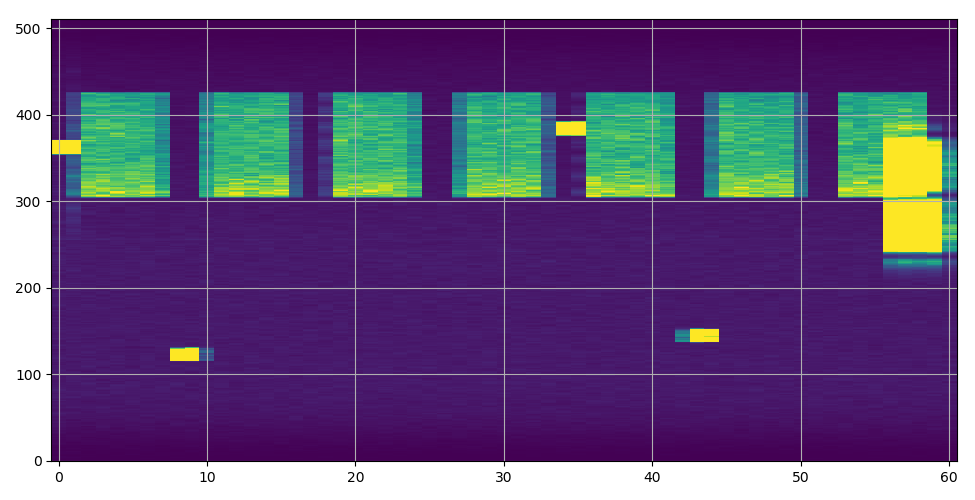

<IPython.core.display.Javascript object>


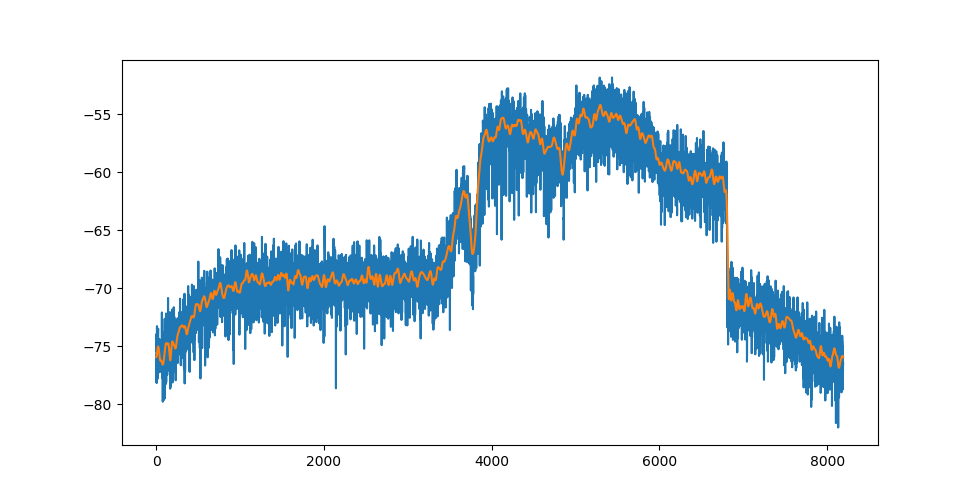

In [30]:
spec8k = spectrogram(f, 1024*8)
# imshow_rescale(spec)
spec8k, tele_parts, _ = preprocess(spec8k,
                                        spect_shrink={'y': 1, 'x': 8},
                                        stride_x=4,
                                        stride_y=4)

spec512 = spectrogram(f, 512)
spec512, tele_parts, _ = preprocess(spec512,
                                        spect_shrink={'y': 1, 'x': 128},
                                        stride_x=4,
                                        stride_y=4)

imshow_rescale(spec8k)
imshow_rescale(spec512)

i = 56
up = scipy.signal.resample(spec512, 1024*8)
plt.figure(figsize=(9.75, 5))
plt.plot(np.log10(spec8k.T[i]) * 10)
plt.plot(np.log10(up.T[i] / 16) * 10)
plt.show()

In [18]:
69-57

12